# What the heck is a collapsed gibbs sampler?

In a chinese restaurant process, the basic structure of it is:
1. Get a new table
2. Given the new table and all the previous tables, we try to see which table our new sample is most likely to join.
    - This involves computing the likelihood of our sample belonging to each table, and then computing the likelihood of the sample in that distribution given the parameterization. 
    - We compute likelihoods for all the tables, and then compute the sigmoid across all of these, which gives us the probability of joining each table. We then randomly sample a table on that basis!
3.  Wash rinse repeat.

However, refitting the parameters like we usually do ('scipy.optimize') is _really_ slow. Instead, via the majick of conjugacy, we get to do it almost for free. 

Its easier to see in code. Below we'll make two normal distributions, means of -2 and 2, both with a std of 1.

(array([ 1.,  6., 14., 19., 12., 12., 19.,  5.,  7.,  5.]),
 array([-0.22340315,  0.23725164,  0.69790643,  1.15856123,  1.61921602,
         2.07987081,  2.5405256 ,  3.0011804 ,  3.46183519,  3.92248998,
         4.38314477]),
 <BarContainer object of 10 artists>)

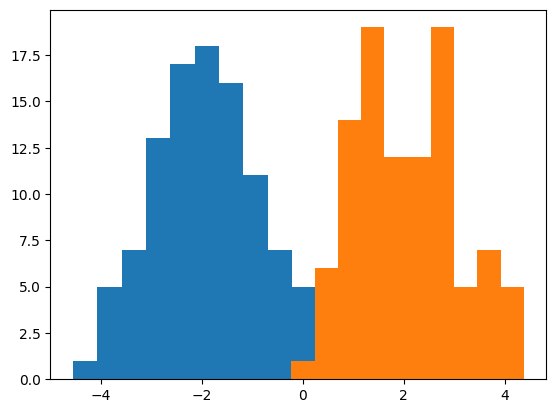

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some synthetic 1D data
np.random.seed(0)
X = np.concatenate([
    np.random.normal(-2, 1, size=100),
    np.random.normal(2, 1, size=100)
])

# Showing that we created two univariate distributions.
plt.hist(X[:100])
plt.hist(X[100:])

# Log Predictive

The basic structure here is we want a system that updates a distribution. We want it to be flexible enough that we can work with a single new sample in a useful way, but also that updates our parameterization in proportion to how many samples there are. To do this, we supply a global, uninformative prior distribution (mean of zero, variance of std^2 = 1^2 = 1), we have some number of items that are already part of the table (in the case of a new table, this would be an empty array), and we have a new item.

Our probability uses our new data point ($x_{new}$), data points in cluster k currently ($x_{k}$), our prior mean ($mu_0$ = 0), our prior variance ($tau^2$ = 1), and the empirical variance ($\sigma^2$, which defaults to our prior).

We don't need to go into the calculation to see how the method works. Just know that this will compute the log-likelihood of a normal distribution.

In [17]:
def log_predictive(x_new, x_k, mu0=0, tau2=1, sigma2=None):
    """Log predictive probability of x_new given data in cluster k"""
    n = len(x_k)
    
    if n == 0:
        var = sigma2 + tau2 if sigma2 is not None else 1 + tau2  # fallback if sigma2 not provided
        return -0.5 * np.log(2 * np.pi * var) - 0.5 * x_new**2 / var
    else:
        x_bar = np.mean(x_k)
        
        # Compute empirical variance if sigma2 not given
        if sigma2 is None:
            if n > 1:
                sigma2_emp = np.var(x_k, ddof=1)  # unbiased sample variance
            else:
                sigma2_emp = 1  # fallback for single data point
        else:
            sigma2_emp = sigma2

        var = sigma2_emp * (1 + 1 / (n + sigma2_emp / tau2))
        mean = (n * x_bar + (sigma2_emp / tau2) * mu0) / (n + sigma2_emp / tau2)
        
        return -0.5 * np.log(2 * np.pi * var) - 0.5 * (x_new - mean)**2 / var


# Collapsed Gibbs Sampler

This shows the actual logic for sampling. We have cluster assignments, and a dictionary of clusters. We go through each cluster and get the log probability associated with each of the clusters. For a new cluster, we have a parameter alpha that controls the rate at which we construct new tables (higher values favor more tables). For currently existing tables, the number of people at the table determines how likely elements are to join that new table, which encourages clustering. After calculating all the log-likelihoods, we compute the multinomial probability of joining each table (thats the `np.exp(log_probs - np.max(log_probs))` and `probs /= np.sum(probs)` portion), and then we sample one of the tables. We do this for a few iterations and we get cluster assignments for each element.

alpha typically is `expected_number_of_clusters / np.log(X)`, but this can be fairly robust to model misspecification, which is a nice feature to have! We'll show this off by using alpha = 1.0, which I kind of like to think of as the null hypothesis (no clusters, just one big sample), though thats not really how it works...

In [42]:
from tqdm import tqdm
from collections import defaultdict

alpha = 1.0 / np.log(len(X))

clusters = defaultdict(list)
assignments = np.array([-1] * len(X))  # -1 means unassigned

for epoch in tqdm(range(100)):
    # for each element in X
    for ix, x_new in enumerate(X):
        # save old assignments
        k_old = assignments[ix]
        assignments[ix] = -1 # reset assignment

        if k_old != -1:  # don't try to remove if it's unassigned
            clusters[k_old].remove(ix)
            if len(clusters[k_old]) == 0:
                del clusters[k_old]


        if len(clusters[k_old]) == 0:
            del clusters[k_old]

        # question: which cluster should we assign this new data point to?
        labels = list(clusters.keys()) + ['new']
        log_probs = []

        for k in labels:
            if k == 'new':
                # If we are assigning to a new cluster, we use the prior.
                log_prob = log_predictive(x_new, np.array([])) + np.log(alpha)
            else:
                # Otherwise, we use the existing cluster.
                log_prob = log_predictive(x_new, np.array(X[clusters[k]])) + np.log(len(clusters[k]))

            log_probs.append(log_prob)

        probs = np.exp(log_probs - np.max(log_probs))
        probs /= np.sum(probs)

        k_new = np.random.choice(labels, p=probs)

        if k_new == 'new':
            k_new = max(clusters.keys(), default=-1) + 1

        assignments[ix] = k_new
        clusters[int(k_new)].append(ix)

100%|██████████| 100/100 [00:00<00:00, 139.56it/s]


Even after misspecifying the model, we see the model definitely prefers 2 major clusters, and if we look at those clusters' empirical means and std...

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1])

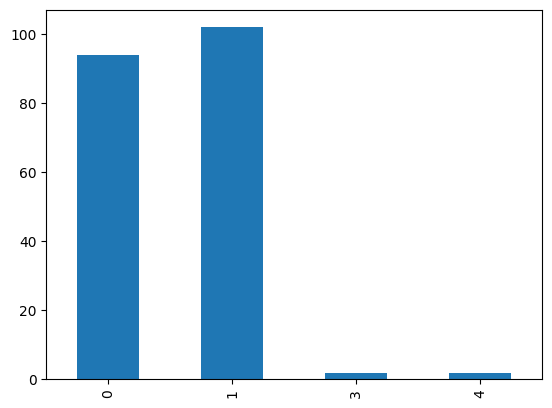

In [43]:
import pandas as pd
pd.Series(assignments).value_counts().sort_index().plot(kind='bar')
assignments

In [44]:
print("Cluster 1:")
print(f"mu = {np.mean([X[i] for i in clusters[0]])}, std = {np.std([X[i] for i in clusters[0]])}\n")

print("Cluster 2:")
print(f"mu = {np.mean([X[i] for i in clusters[1]])}, std = {np.std([X[i] for i in clusters[1]])}\n")

Cluster 1:
mu = -2.01146803281645, std = 0.9843857600415876

Cluster 2:
mu = 2.002184032430312, std = 1.1264585715310347



We've learned our distributions! Basically, any Chinese Restaurant Process is going to run exactly like this, and we can 'endow' these tables with any distribution we want, as long as we have some way to update the parameters (ideally quickly) when performing inference.